<a href="https://colab.research.google.com/github/Reversin/NeuralNetworkC3_lab2/blob/new_branch/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4

ФИО:  Шамарин Сергей Алексеввич   
Группа: БИВТ-20-6

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)

100%|██████████| 169001437/169001437 [00:01<00:00, 102480015.34it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


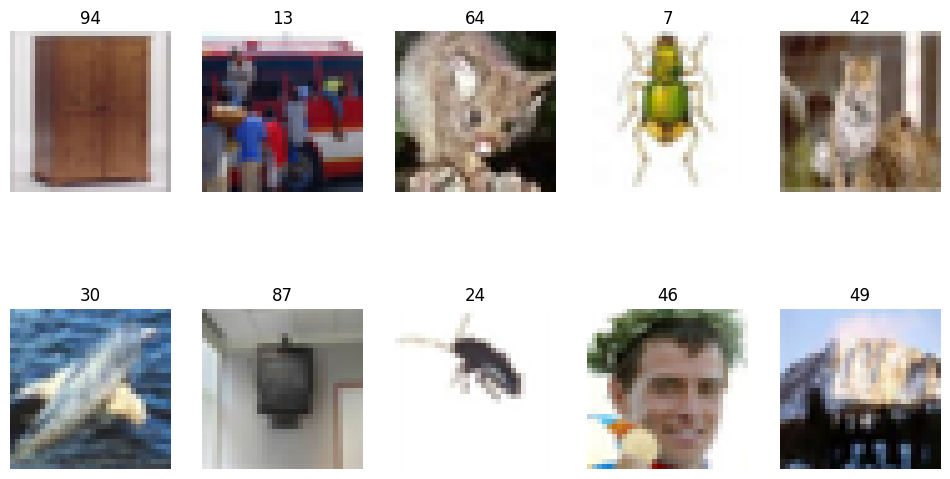

In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(10):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.subplots_adjust(hspace=0.5)
    plt.show()

random_indexes = np.random.randint(0, len(train_dataset), size=10)
random_images = [np.array(train_dataset[i][0]) for i in random_indexes]
random_labels = [train_dataset[i][1] for i in random_indexes]
show_images(random_images, random_labels)

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = self.transform(image)
        return image, label
    def __len__(self):
        return len(self.dataset)

train_dataset = MyDataset(train_dataset)
test_dataset = MyDataset(test_dataset)
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class MyNN(nn.Module):
    def __init__(self):
        super(MyNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 32 * 32, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss/len(test_dataloader):.4f} | Accuracy: {100*correct/total:.2f}%')

Epoch [1/15] | Loss: 16.8105 | Accuracy: 20.03%
Epoch [2/15] | Loss: 11.7445 | Accuracy: 39.44%
Epoch [3/15] | Loss: 7.4341 | Accuracy: 59.27%
Epoch [4/15] | Loss: 3.2491 | Accuracy: 81.75%
Epoch [5/15] | Loss: 1.1219 | Accuracy: 93.76%
Epoch [6/15] | Loss: 0.6065 | Accuracy: 96.76%
Epoch [7/15] | Loss: 0.5593 | Accuracy: 96.76%
Epoch [8/15] | Loss: 0.5604 | Accuracy: 96.63%
Epoch [9/15] | Loss: 0.4598 | Accuracy: 97.37%
Epoch [10/15] | Loss: 0.4367 | Accuracy: 97.38%
Epoch [11/15] | Loss: 0.4188 | Accuracy: 97.44%
Epoch [12/15] | Loss: 0.3538 | Accuracy: 97.79%
Epoch [13/15] | Loss: 0.3527 | Accuracy: 97.85%
Epoch [14/15] | Loss: 0.3321 | Accuracy: 98.03%
Epoch [15/15] | Loss: 0.3452 | Accuracy: 97.94%


In [8]:
import torchvision.models as models
import torch.nn as nn

pretrained_model = models.resnet18(pretrained=True)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 100)
model_transfer = pretrained_model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer.parameters(), lr=0.001)
num_epochs = 15

for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model_transfer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(test_dataloader):.4f}, Accuracy: {100*correct/total:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Loss: 14.4582, Accuracy: 27.63%
Epoch [2/15], Loss: 10.6306, Accuracy: 42.97%
Epoch [3/15], Loss: 9.0563, Accuracy: 49.91%
Epoch [4/15], Loss: 7.6303, Accuracy: 56.52%
Epoch [5/15], Loss: 6.4614, Accuracy: 62.33%
Epoch [6/15], Loss: 5.4964, Accuracy: 67.66%
Epoch [7/15], Loss: 4.6846, Accuracy: 71.59%
Epoch [8/15], Loss: 3.9253, Accuracy: 75.76%
Epoch [9/15], Loss: 3.4415, Accuracy: 79.00%
Epoch [10/15], Loss: 2.8079, Accuracy: 82.32%
Epoch [11/15], Loss: 2.4398, Accuracy: 84.43%
Epoch [12/15], Loss: 1.9185, Accuracy: 87.73%
Epoch [13/15], Loss: 1.8635, Accuracy: 88.04%
Epoch [14/15], Loss: 1.5434, Accuracy: 89.91%
Epoch [15/15], Loss: 1.4691, Accuracy: 90.50%


In [10]:
model_transfer.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model_transfer(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {test_loss/len(test_dataloader):.4f} | Test Accuracy: {100*correct/total:.2f}%')

Test Loss: 2.6686 | Test Accuracy: 49.98%
